In [1]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
Mon Apr 12 12:08:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |         

In [1]:
!pip3 install keras==2.2.5

%tensorflow_version 1.x
import tensorflow as tf
from keras import backend as K
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
#import tensorflow as tf
#import keras
#print(keras.__version__)
print(tf.__version__)

1.15.2


In [3]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 14.06 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [5]:
import sys
import os
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean

In [6]:
os.chdir('Mask_RCNN/samples')

In [7]:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
!ls "/content/gdrive/My Drive/Colab Notebooks/mrcnn"

best_weights_dataset_base.h5	  coco_pretrained_weights.h5  dataset_reduzido
best_weights_dataset_reduzido.h5  dataset_base		      mrcnn_model.ipynb


In [10]:
from mrcnn.utils import Dataset
from matplotlib import pyplot
from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from matplotlib.patches import Rectangle

In [11]:
class PestDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "WF")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		# find all images
		for filename in sorted(listdir(images_dir)):
			# extract image id
			image_id = filename[:-4]
			# skip bad images
			#if image_id in ['00090']:
			#	continue
			# skip all images after 1244 if we are building the train set #1244			
			if is_train and int(image_id) >= 1244:
				continue
			# skip all images before 1244 if we are building the test/val set #1244
			if not is_train and int(image_id) < 1244:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
 
	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height
 
	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('WF'))
		return masks, asarray(class_ids, dtype='int32')
 
	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

In [13]:
# /content/gdrive/My Drive/Colab Notebooks/mrcnn/dataset
# /content/gdrive/My Drive/Colab Notebooks/mrcnn/coco_pretrained_weights.pt

# model.py
# 2360: workers=1, default=0
# 2374: use_multiprocessing=False, default=True


class PestConfig(Config):
	# Give the configuration a recognizable name
	NAME = "pest_cfg"
	# Number of classes (background + wf)
	NUM_CLASSES = 1 + 1
	# Number of training steps per epoch
	STEPS_PER_EPOCH = 10
	BATCH_SIZE = 8
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
	BACKBONE = "resnet101"
	IMAGE_MIN_DIM = 640
	IMAGE_MAX_DIM = 640 
#	DETECTION_MIN_CONFIDENCE = 0.7
	RPN_NMS_THRESHOLD = 0.7    
	RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
	RPN_ANCHOR_RATIOS = [0.5, 1, 2]
 
# prepare train set
train_set = PestDataset()
train_set.load_dataset('/content/gdrive/My Drive/Colab Notebooks/mrcnn/dataset_reduzido', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = PestDataset()
test_set.load_dataset('/content/gdrive/My Drive/Colab Notebooks/mrcnn/dataset_reduzido', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# prepare config
config = PestConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)

Train: 117
Test: 30

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MAS

In [16]:
# load weights (mscoco) and exclude the output layers
#model.load_weights('/content/gdrive/My Drive/Colab Notebooks/mrcnn/best_weights_dataset_base.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
#odel.load_weights('/content/gdrive/My Drive/Colab Notebooks/mrcnn/best_weights_dataset_base.h5', by_name=True)

#model.load_weights('/content/gdrive/My Drive/Colab Notebooks/mrcnn/coco_pretrained_weights.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

#model.load_weights('/content/Mask_RCNN/samples/pest_cfg20210323T2047/mask_rcnn_pest_cfg_0030.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
model.load_weights('/content/Mask_RCNN/samples/pest_cfg20210412T1213/mask_rcnn_pest_cfg_0010.h5', by_name=True)

# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=20, layers="all")

Re-starting from epoch 10

Starting at epoch 10. LR=0.001

Checkpoint Path: ./pest_cfg20210412T1213/mask_rcnn_pest_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 11/20
10/10 [==============================] - 194s 19s/step - loss: 1.8587 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 0.6456 - mrcnn_class_loss: 0.1702 - mrcnn_bbox_loss: 0.5717 - mrcnn_mask_loss: 0.4210 - val_loss: 1.7538 - val_rpn_class_loss: 0.0693 - val_rpn_bbox_loss: 0.6148 - val_mrcnn_class_loss: 0.2051 - val_mrcnn_bbox_loss: 0.4112 - val_mrcnn_mask_loss: 0.4533
Epoch 12/20
 4/10 [===========>..................] - ETA: 6s - loss: 1.7946 - rpn_class_loss: 0.1737 - rpn_bbox_loss: 0.6217 - mrcnn_class_loss: 0.1925 - mrcnn_bbox_loss: 0.3812 - mrcnn_mask_loss: 0.4256

/usr/local/lib/python3.7/dist-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


10/10 [==============================] - 121s 12s/step - loss: 1.8337 - rpn_class_loss: 0.1439 - rpn_bbox_loss: 0.5559 - mrcnn_class_loss: 0.2480 - mrcnn_bbox_loss: 0.4359 - mrcnn_mask_loss: 0.4500 - val_loss: 1.6646 - val_rpn_class_loss: 0.1257 - val_rpn_bbox_loss: 0.4698 - val_mrcnn_class_loss: 0.2566 - val_mrcnn_bbox_loss: 0.3933 - val_mrcnn_mask_loss: 0.4192
Epoch 13/20
10/10 [==============================] - 87s 9s/step - loss: 1.6078 - rpn_class_loss: 0.0893 - rpn_bbox_loss: 0.5136 - mrcnn_class_loss: 0.1588 - mrcnn_bbox_loss: 0.4109 - mrcnn_mask_loss: 0.4352 - val_loss: 1.8987 - val_rpn_class_loss: 0.0839 - val_rpn_bbox_loss: 0.4921 - val_mrcnn_class_loss: 0.4018 - val_mrcnn_bbox_loss: 0.5042 - val_mrcnn_mask_loss: 0.4167
Epoch 14/20
10/10 [==============================] - 80s 8s/step - loss: 1.3777 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 0.4814 - mrcnn_class_loss: 0.1557 - mrcnn_bbox_loss: 0.3071 - mrcnn_mask_loss: 0.3733 - val_loss: 1.7828 - val_rpn_class_loss: 0.0955 - va

In [17]:
!ls "/content/Mask_RCNN/samples/pest_cfg20210324T1704/mask_rcnn_pest_cfg_0020.h5

/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [18]:
# /content/pest_cfg20201111T1311/mask_rcnn_pest_cfg_0005.h5

# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "pest_cfg"
	# number of classes (background + wf)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

  
 
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP
 
# load the train dataset
train_set = PestDataset()
train_set.load_dataset('/content/gdrive/My Drive/Colab Notebooks/mrcnn/dataset_reduzido', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# load the test dataset
test_set = PestDataset()
test_set.load_dataset('/content/gdrive/My Drive/Colab Notebooks/mrcnn/dataset_reduzido', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

Train: 117
Test: 30


Instructions for updating:
Use `tf.cast` instead.


In [24]:
# load model weights
model.load_weights("/content/Mask_RCNN/samples/pest_cfg20210412T1213/mask_rcnn_pest_cfg_0019.h5", by_name=True)
#model.load_weights('/content/gdrive/My Drive/Colab Notebooks/mrcnn/best_weights_dataset_base.h5', by_name=True)

#train_mAP = evaluate_model(train_set, model, cfg)
#print("Train mAP: %.3f" % train_mAP)

# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.4f" % test_mAP)

Re-starting from epoch 19
Test mAP: 0.4820
time: 1min 51s (started: 2021-04-12 12:57:49 +00:00)


In [25]:
def plot_predicted(dataset, model, cfg, id):
  
	pyplot.figure(figsize=(20,40))

	# load the image and mask
	image = dataset.load_image(id)

	# convert pixel values (e.g. center)
	scaled_image = mold_image(image, cfg)
	# convert image into one sample
	sample = expand_dims(scaled_image, 0)
	# make prediction
	yhat = model.detect(sample, verbose=0)[0]

	# plot raw pixel data
	pyplot.imshow(image)
	pyplot.title('Predicted')
	ax = pyplot.gca()
	# plot each box
	for box in yhat['rois']:
		# get coordinates
		y1, x1, y2, x2 = box
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='red')
		# draw the box
		ax.add_patch(rect)

	print(len(yhat['rois']))
# show the figure
pyplot.show()


time: 19.5 ms (started: 2021-04-12 12:59:43 +00:00)


In [22]:
!pip install ipython-autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
59


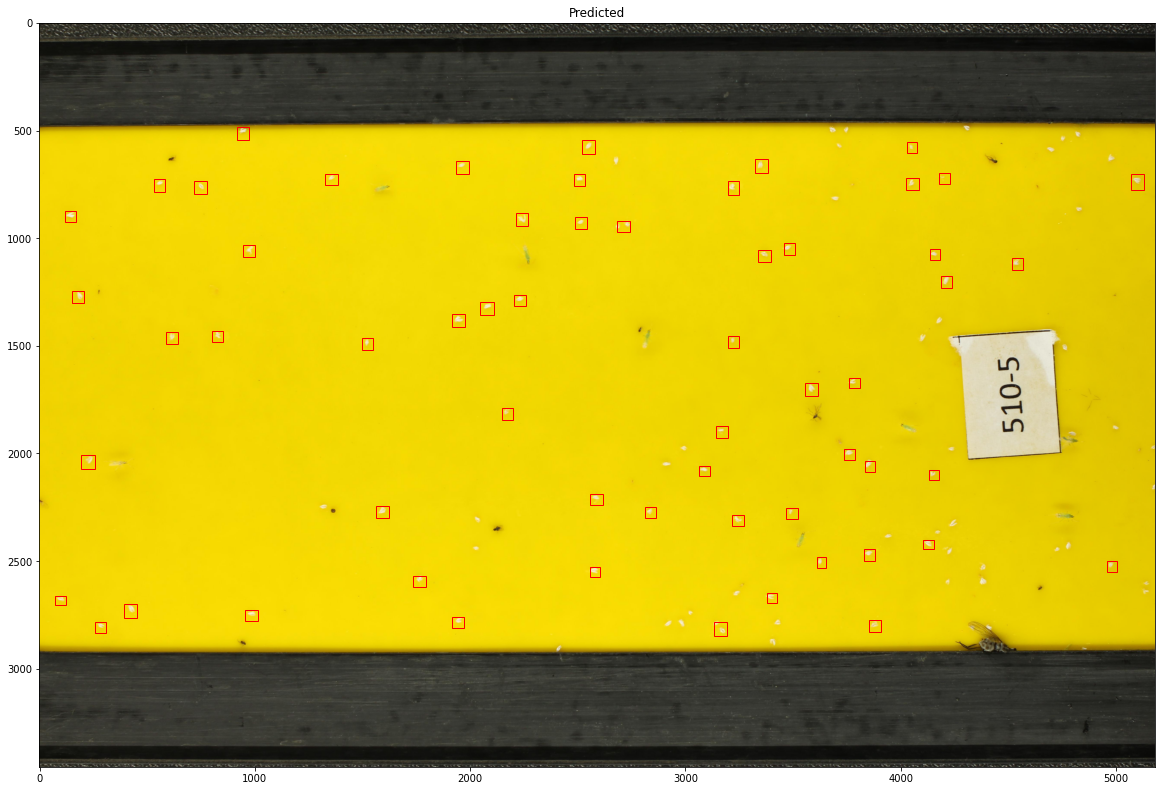

time: 20.4 s (started: 2021-04-12 13:41:13 +00:00)


In [64]:
%load_ext autotime
plot_predicted(test_set,model,cfg, 4)

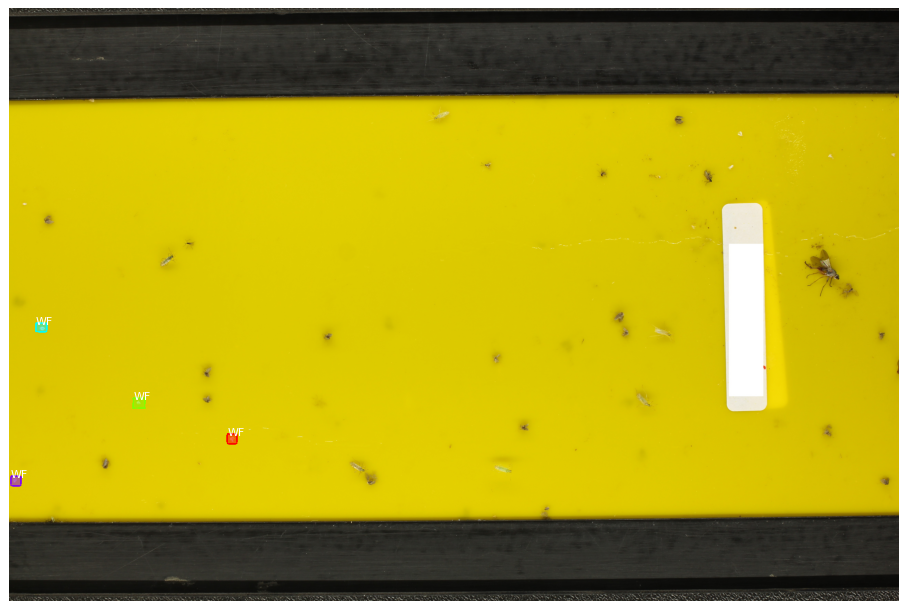

time: 8.1 s (started: 2021-04-12 13:42:34 +00:00)


In [65]:
#/content/gdrive/My Drive/Colab Notebooks/mrcnn/dataset

# train set
train_set = PestDataset()
train_set.load_dataset('/content/gdrive/My Drive/Colab Notebooks/mrcnn/dataset_reduzido', is_train=True)
train_set.prepare()
# define image id
image_id = 9
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)